# NISQAI One-Qubit Quantum Neural Network Adapted for Qiskit


***
### Contributors
#### Add here the contributors:
Pierre Decoodt

## Introduction

This is a proof of concept for the assessment on Qiskit of a NISQAI classifier$^{[1]}$.
A one-qubit neural network is tested on Aer based noise free simulation (NFS) and device noise simulation (DNS), and also on real superconducting quantum calculating device (SQC).

The protocol follows the steps described in a previous Qiskit tutorial $^{[2]}$ using quantum state tomography $^{[3]}$ for assessing fidelity.

The last part consist of testing training and prediction by NFS and DNS.

NB: I use the term SQC instead of NISQ because the original Preskill paper $^{[4]}$ specifies as "NISQ" quantum computers with 50-100 qubits.

In [1]:
#Import packages
# NB running this cell induces a ChangedInMarshmallow3Warning for the moment. This warning can be safely ignored.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy.optimize import minimize

# import from qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, compile
from qiskit.converters import qobj_to_circuits
from qiskit import Aer, IBMQ
from qiskit.providers.aer import noise

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram        
from qiskit.tools.qi.qi import state_fidelity, outer
from qiskit.tools.qi.qi import outer
from qiskit.quantum_info import state_fidelity
from qiskit.tools.monitor import job_monitor, backend_overview
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info.analyzation.average import average_data

C:\Users\decpi\Anaconda3\envs\q7env\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
Aer.backends() # No need for credentials for running the next cells until next warning

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

## 1. Data  Encoding

### Generating Data

In [3]:
# set random seed for reproducible results
SEED = 1059123109
np.random.seed(seed=SEED)

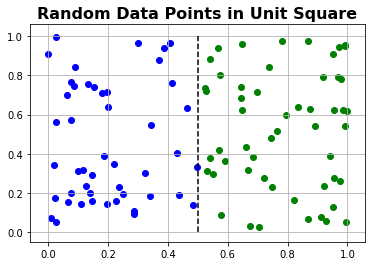

In [4]:
# generate data points distributed uniformly at random in [0, 1) x [0, 1)
npoints = 100
data = np.random.rand(npoints, 2)

def predicate(point):
    """Returns true if the point satisfies the predicate, else false."""
    return True if point[0] <= 0.5 else False

# separate the data with a linear boundary y = x
labels = np.array([1 if predicate(p) else 0 for p in data])

# plot the line y = x
xs = np.linspace(0, 1, 100)
ys = 0.5 * np.ones_like(xs)
plt.plot(ys, xs, '--k')

# plot the data with the color key BLUE = 0 = LEFT, GREEN = 1 = RIGHT
for i in range(npoints):
    if labels[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)
    
# title and axis lables
plt.title("Random Data Points in Unit Square", fontweight="bold", fontsize=16)

# put on a grid and show the plot
plt.grid()
plt.show()

### Qubit Encoding

In [5]:
# encode the classical data via a simple linear "qubit encoding"
qdata = np.zeros_like(data)
for (index, point) in enumerate(data):
    qdata[index][0] = np.pi * point[0]
    qdata[index][1] = 2 * np.pi * point[1]

## 2. State Preparation

As explained is the NISQAI one-qubit classifier description$^{[1]}$, the one-qubit encoding is achieved by realizing the following initial state: 
 
$$|\psi\rangle = \cos(\frac {\theta}{2}) |0\rangle + e^{i \phi} \sin(\frac {\theta}{2})|1\rangle $$


The unitary taking the $|0\rangle$ to the above state is: 

$$
S(\theta, \phi) = \begin{pmatrix}
\cos(\frac {\theta}{2}) & e^{-i \phi}\sin(\frac {\theta}{2}) \\
e^{i \phi} \sin(\frac {\theta}{2}) & - \cos(\frac {\theta}{2})
\end{pmatrix}
$$


Such an operation is not currently directly available in Qiskit to our knowledge. We therefore use arbitrary initialization in order to encode the qubit $^{[5]}$.

A check of the results of this arbitrary initialization follows:

In [6]:
# Checking arbitrary initialization
n = 1
for i in range(5,56,5) : # modify here if wishe
    # create a n-qubit quantum register
    qrt = QuantumRegister(n)
    crt = ClassicalRegister(n)
    check_sta = QuantumCircuit(qrt,crt , name='check_sta')

    # pick an encoded data point
    theta, phi = qdata[i]

    # desired vector
    desired_vector = [np.cos(theta / 2), np.exp(1j * phi) * np.sin(theta / 2)]
    qrt_vector = []

    # Initialize a 1-qubit quantum state using the arbitrary method                     
    qrt_vector.append(qrt[0])
    check_sta.initialize(desired_vector, qrt_vector)

    # Measurement circuit
    measuring = QuantumCircuit(qrt,crt , name='measuring')
    for i in range(n) :
        measuring.measure(qrt[i] , crt[i])
    test_check = check_sta+measuring

    # noise free simulation (NFS)
    mode = "NFS"

    # test circuit "check_sta" : Noise free model on simulator
    backend_sim = Aer.get_backend('qasm_simulator')
    shots = 8192
    job_noisefree = execute(test_check, backend_sim, shots=shots)    
    count = job_noisefree.result().get_counts(test_check)
    
    # get the output probabilities
    observable_1 =  {'1' : 1, '0' : 0}
    observable_0 =  {'0' : 1, '1' : 0}
    fr_obs1 = int(average_data(count,observable_1)*8192)
    fr_obs0 = int(average_data(count,observable_0)*8192)
    
    fr_theo0 = int(abs(np.cos(theta / 2)**2)*shots)
    fr_theo1 = int(abs(np.exp(1j * phi) * np.sin(theta / 2)**2)*shots)
    print(round(theta,3), round(phi,3),"   ", fr_theo0,"vs", fr_obs0,"--", fr_theo1,"vs", fr_obs1)  

3.122 5.969     0 vs 2 -- 8191 vs 8190
0.348 0.911     7946 vs 7946 -- 245 vs 246
1.652 4.618     3765 vs 3849 -- 4426 vs 4343
2.919 0.365     101 vs 94 -- 8090 vs 8098
2.582 1.018     623 vs 592 -- 7568 vs 7600
0.002 5.703     8191 vs 8192 -- 0 vs 0
2.986 5.712     49 vs 34 -- 8142 vs 8158
3.064 1.62     12 vs 15 -- 8179 vs 8177
1.516 0.87     4320 vs 4356 -- 3871 vs 3836
3.131 0.308     0 vs 0 -- 8191 vs 8192
2.118 0.197     1965 vs 1949 -- 6226 vs 6243


In [7]:
# Determine the job
n = 1

# create a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
initial_state = QuantumCircuit(qr, cr, name='initial_state')

# pick a particular encoded data point
theta, phi = qdata[0]

# desired vector
desired_vector = [np.cos(theta / 2), np.exp(1j * phi) * np.sin(theta / 2)]
qr_vector = []

# Initialize a 1-qubit quantum state using the arbitrary method                     
qr_vector.append(qr[0])
initial_state.initialize(desired_vector, qr_vector)

# Measurement circuit
measuring = QuantumCircuit(qr, cr, name='measuring')
for i in range(n) :
    measuring.measure(qr[i] , cr[i])
test = initial_state+measuring

### Test the arbitrary initialization of the state by noise free simulation

In [8]:
# QASM from test
QASM_source = test.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q11[1];
creg c11[1];
ry(2.98797789579958) q11[0];
rz(0.789805554415850) q11[0];
measure q11[0] -> c11[0];



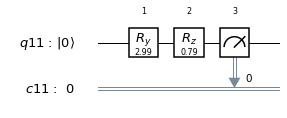

In [9]:
# Draw the circuit
my_style = {'latexdrawerstyle': False, 'cregbundle': True, 'fold': 30, 'showindex': True}
test.draw(output='mpl', style=my_style)

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

Date (DMY): 10/02/2019 10:17:59
{'0': 8, '1': 992}
theta = 2.987977895799584 phi = 0.7898055544158503


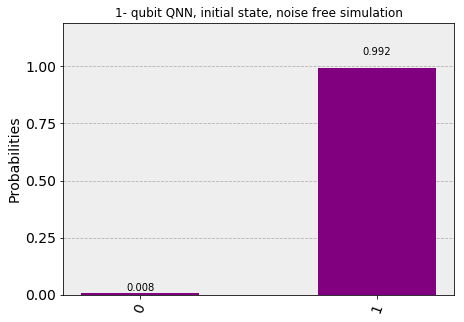

In [10]:
# noise free simulation (NFS)
mode = "NFS"

# Test circuit "initial_state" : Noise free model on simulator
backend_sim = Aer.get_backend('qasm_simulator')
shots = 1000
job_noisefree = execute(test, backend_sim, shots=shots)
job_monitor(job_noisefree)

count = job_noisefree.result().get_counts(test)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print(count)
print('theta =', theta, 'phi =', phi)
plot_histogram(count, color=['purple'], 
               title=str(n) + '- qubit QNN, initial state, noise free simulation')

## 3. Unitary Evolution

In [11]:
def unitary(angles):
    """Returns a circuit implementing the unitary Rz(theta0) P Rz(theta1) P Rz(theta2)
    where thetea0 = angles[0], theta1 = angles[1], and theta2 = angles[2] and
    P = Rx(pi / 2) is a pi / 2 pulse.
    """
    
    circuit = QuantumCircuit(qr, cr)
    circuit.rz(angles[0], qr[0])
    circuit.rx(np.pi / 2, qr[0]),
    circuit.rz(angles[1], qr[0]),
    circuit.rx(np.pi / 2, qr[0]),
    circuit.rz(angles[2], qr[0])
    
    return circuit

In [12]:
# test angles
angles = 2 * np.pi * np.random.rand(3)
my_state = initial_state + unitary(angles)
qprog = my_state + measuring

# QASM
QASM_source = qprog.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q11[1];
creg c11[1];
ry(2.98797789579958) q11[0];
rz(0.789805554415850) q11[0];
rz(0.314283559730307) q11[0];
rx(1.57079632679490) q11[0];
rz(4.27779036629818) q11[0];
rx(1.57079632679490) q11[0];
rz(3.31959735414771) q11[0];
measure q11[0] -> c11[0];



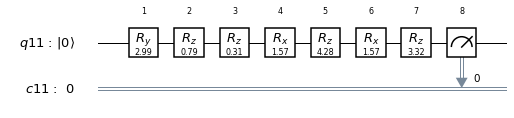

In [13]:
# Draw the circuit
my_style = {'latexdrawerstyle': False, 'cregbundle': True, 'fold': 30, 'showindex': True}
qprog.draw(output='mpl', style=my_style)

### Test the circuit using a noise free simulation

Date (DMY): 10/02/2019 10:18:14
{'0': 252, '1': 748}
theta = 2.987977895799584 phi = 0.7898055544158503


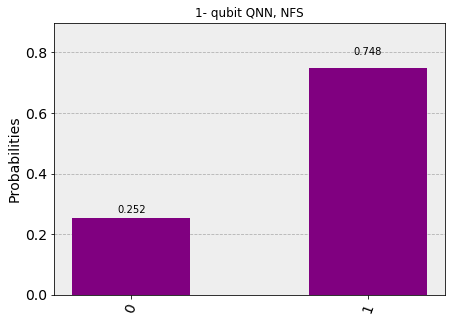

In [14]:
# noise free simulation (NFS)
mode = "NFS"

# run the quantum neural network program

shots = 1000
job_noisefree = execute(qprog, backend_sim, shots=shots)

noisefree_count = job_noisefree.result().get_counts(qprog)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print(noisefree_count)
print('theta =', theta, 'phi =', phi)
plot_histogram(noisefree_count, color=['purple'], 
               title=str(n) + '- qubit QNN, ' + mode)

### State tomography and quantum fidelity in noise free device simulation

In [15]:
# Execute state tomography using noise free quantum device simulation
mode = "NFS"
# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

backend_tomo = Aer.get_backend('qasm_simulator') # for simulation

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1000

my_state_job = execute(my_state_tomo_circuits, backend_tomo, shots=shots)
job_monitor(my_state_job)
my_state_tomo_result = my_state_job.result()    
        
# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit QNN on', backend_tomo,
      ", shots:", shots, ", mode:", mode, "theta:", theta, 'phi:', phi)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

Date (DMY): 10/02/2019 10:18:18
Tomography 1-qubit QNN on qasm_simulator , shots: 1000 , mode: NFS theta: 2.987977895799584 phi: 0.7898055544158503
Fidelity with theoretical ideal state
F = 0.999933478085305


### From here, you need credentials:

In [16]:
IBMQ.load_accounts()

In [17]:
backend_overview() # you may skip running this cell if you want

ibmq_16_melbourne           ibmqx4
-----------------           ------
Num. Qubits:  14            Num. Qubits:  5
Pending Jobs: 65            Pending Jobs: 469
Least busy:   True          Least busy:   False
Operational:  True          Operational:  True
Avg. T1:      53.7          Avg. T1:      52.1
Avg. T2:      73.0          Avg. T2:      17.2





In [17]:
# Make your choice of real device
#backend_real = least_busy(IBMQ.backends(operational=True, simulator=False))
#backend_real = IBMQ.get_backend('ibmqx4')
backend_real = IBMQ.get_backend('ibmq_16_melbourne')
print(backend_real)

ibmq_16_melbourne


### Prepare noise simulation corresponding to a given quantum device

In [18]:
# Prepare device noise simulation (DNS)

device = backend_real
print("device: ", device)
properties = device.properties()
coupling_map = device.configuration().coupling_map
prepared = False
if device.name() == 'ibmq_16_melbourne' :
    gate_times = [
        ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
        ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
        ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
        ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
        ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
        ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
        ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
    ]
    prepared = True
    
elif device.name() == 'ibmqx4' :
    gate_times = [
        ('u1', None, 0), ('u2', None, 60), ('u3', None, 120),
        ('cx', [1, 0], 340), ('cx', [2, 0], 424), ('cx', [2, 1], 520),
        ('cx', [3, 2], 620), ('cx', [3, 4], 420), ('cx', [4, 2], 920)    
    ]
    prepared = True

else :
    print("No gate times yet defined in this notebook for: ", device)
        
if prepared :
    # Construct the noise model from backend properties and custom gate times
    noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)

    # Get the basis gates for the noise model
    basis_gates = noise_model.basis_gates
    
    print("noise model prepared for", device)


device:  ibmq_16_melbourne
noise model prepared for ibmq_16_melbourne


### Run the algorithm using device noise simulation (DNS)

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

<bound method AerJob.status of <qiskit.providers.aer.aerjob.AerJob object at 0x000001D758C17240>>
Date (DMY): 10/02/2019 10:18:47
{'0': 282, '1': 718}
theta = 2.987977895799584 phi = 0.7898055544158503


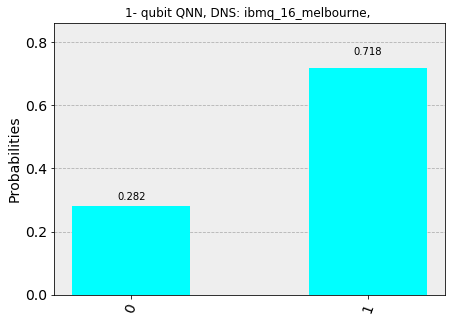

In [19]:
# Execute test using device noise simulation (DNS)

backend_noise = Aer.get_backend('qasm_simulator') # for simulation (DNS)

shots = 1000
mode = "DNS"
job_noise = execute(qprog, backend_noise, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates, shots = shots)
job_monitor(job_noise)

print(job_noise.status)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
noisy_count = job_noise.result().get_counts(qprog) 
print(noisy_count)
print('theta =', theta, 'phi =', phi)
plot_histogram(noisy_count, color=['cyan'],
               title= str(n) + '- qubit QNN, ' + mode + ': {}, '.format(device.name()))

### State tomography and quantum fidelity in device noise simulation (DNS)

In [20]:
# Execute state tomography using device noise simulation (DNS)

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)
my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.    

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

backend_tomo = Aer.get_backend('qasm_simulator') # for simulation

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1000
mode = "DNS"
my_state_job = execute(my_state_tomo_circuits, backend_tomo, 
                               noise_model=noise_model,
                               coupling_map=coupling_map,
                               basis_gates=basis_gates)
job_monitor(my_state_job)
my_state_tomo_result = my_state_job.result()    

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit QNN on', backend_tomo,
      ", shots:", shots, ", mode:", mode, "of", device, "theta:", theta, 'phi:', phi)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

Date (DMY): 10/02/2019 10:18:51
Tomography 1-qubit QNN on qasm_simulator , shots: 1000 , mode: DNS of ibmq_16_melbourne theta: 2.987977895799584 phi: 0.7898055544158503
Fidelity with theoretical ideal state
F = 0.8969037947087841


### Run the algorithm on superconducting quantum computing device (SQC)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

<bound method IBMQJob.status of <qiskit.providers.ibmq.ibmqjob.IBMQJob object at 0x000001D758E22DD8>>
Date (DMY): 10/02/2019 11:34:17
{'0': 309, '1': 715}
theta = 2.987977895799584 phi = 0.7898055544158503


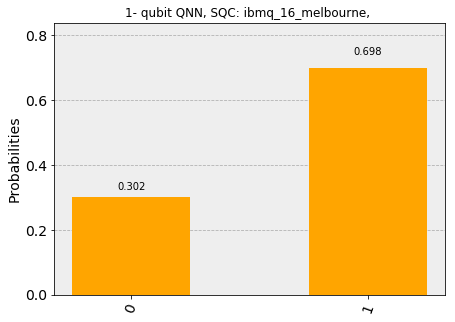

In [21]:
# Execute test using superconducting quantum computing device (SQC)

#Choose the backend
#backend_SQC = Aer.get_backend('qasm_simulator') # for optional test before final experiment 
backend_SQC = device # for a real device

# Execute on SQC and get counts
shots = 1000
if backend_SQC.name() == "qasm_simulator" : # optional test before final experiment 
    mode = "DNS"
    job_real = execute(qprog, backend_SQC, 
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates)
else: # final experiment on real device
    mode = "SQC"
    job_real = execute(qprog, backend_SQC)
    job_monitor(job_real)

print(job_real.status)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
real_count = job_real.result().get_counts(qprog) 
print(real_count)
print('theta =', theta, 'phi =', phi)
plot_histogram(real_count, color=['orange'], 
               title= str(n) + '- qubit QNN, ' + mode + ': {}, '.format(device.name()))

### State tomography and quantum fidelity on superconducting quantum computing device (SQC)

In [219]:
# Execute state tomography on superconducting quantum computing device (SQC)
mode = "SQC"
# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

#Choose the backend
#backend_tomo = Aer.get_backend('qasm_simulator') # optional test before final experiment
backend_tomo = device # for real device

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1000

# loop: 27 circuits maximum per job to avoid exceeding the allowed limit for the real device.  
n_circ = 3**n
i_max = min(27,n_circ)
my_jobs = []
index_job = -1
for i in range(0,n_circ,i_max) :
    circs =[]
    for j in range(i, i+i_max):
        circs.append(my_state_tomo_circuits[j])
    if backend_tomo.name() == "qasm_simulator" : # optional test before final experiment
        mode = "DNS"
        my_state_job = execute(circs, backend_tomo, 
                               noise_model=noise_model,
                               coupling_map=coupling_map,
                               basis_gates=basis_gates)
    else: # final experiment on real device
        mode = "SQC" 
        my_state_job = execute(circs, backend_tomo, shots=shots)
    my_jobs.append(my_state_job)
    index_job = index_job + 1 
    job_monitor(my_jobs[index_job], monitor_async = True)
    
    my_state_new_result = my_state_job.result()
    if i == 0:
        my_state_tomo_result = my_state_new_result
    else:
        my_state_tomo_result = my_state_tomo_result +  my_state_new_result

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# Quantum fidelity

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print('Tomography',str(n)+'-qubit classifier on', backend_tomo,
      ", shots:", shots, ", mode:", mode, device, "theta:", theta, 'phi:', phi)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with theoretical ideal state')
print('F =', F_fit)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Date (DMY): 07/02/2019 22:32:13
Tomography 1-qubit classifier on ibmq_16_melbourne , shots: 1000 , mode: SQC ibmq_16_melbourne theta: 2.987977895799584 phi: 0.7898055544158503
Fidelity with theoretical ideal state
F = 0.8859731304253138


### Comparing NFS, DNS and SQC
The results mentioned above for the DNS and SQC experiments are illustrated together in the next graphs:

Herafter a comparison of the histograms of estimated outcome probabilities obtained during noise-free simulation, DNS and SQC experiments on ibmqx4 using Qiskit 0.7.

In [22]:
device_name = device.name()

In [23]:
# !!! Skip this cell if you want to see the results for a new run of the program
#Date (DMY): 07/02/2019
device_name = "ibm_16_melbourne"
noisefree_count = {'1': 721, '0': 279}
noisy_count = {'1': 711, '0': 289}
real_count = {'1': 695, '0': 305}

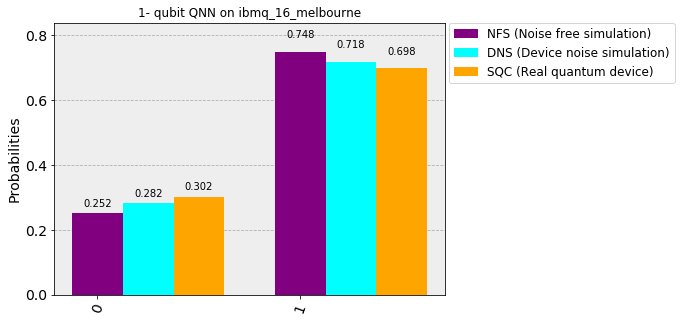

In [24]:
# NFS vs DSN vs SQC, count histograms
plot_histogram([noisefree_count, noisy_count, real_count], 
               title= str(n) + '- qubit QNN on ' + device_name,
               color=['purple','cyan', 'orange'], bar_labels=True,
               legend = ['NFS (Noise free simulation)', 'DNS (Device noise simulation)','SQC (Real quantum device)']) 

### Quantum Fidelity

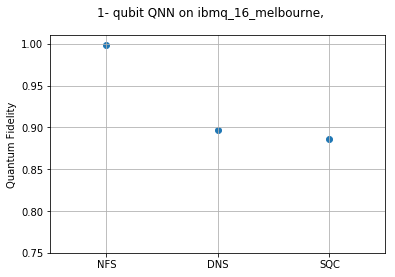

In [26]:
names = ['NFS','DNS','SQC']
legend = ['NFS (Noise free simulation)', 'DNS (Device noise simulation)','SQC (Real quantum device)']

fidelities = [0.999,0.897,0.886]
plt.ylabel('Quantum Fidelity')
plt.suptitle(str(n) + '- qubit QNN on {}, '.format(device.name()))
plt.axis([-0.5,2.5,0.75,1.01])
plt.grid()
plt.scatter(names, fidelities)
            
plt.show()

## Several subroutines

In [35]:
def obj_simple(angles, shots=1000, verbose=False):
    """Returns the number of zero outputs of a single training example."""
    # make the program
    qprog = make_program([theta, phi], angles)
    if verbose:
        QASM_source = qprog.qasm()
        print(QASM_source)
    if mode == "NFS":        
        dist = execute(qprog, backend_sim, shots=shots)
    elif mode == "DNS":
        dist = execute(qprog, backend_noise, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates, shots = shots)
        
    dist_count = dist.result().get_counts(qprog)
    observable =  {'1' : 1}
    obj = average_data(dist_count,observable)/shots    
    print("The current value of the objective function is:", obj, end="\r")

    return obj

In [28]:
def make_program(pangles, uangles): # to be modified if n>1!
    """Returns a  program that prepares the state according
    to pangles and applies the unitary according to uangles.
    """
    new_state = QuantumCircuit(qr, cr)
    # desired vector
    desired_vector = [np.cos(pangles[0] / 2), np.exp(1j * pangles[1]) * np.sin(pangles[0] / 2)]
    qr_vector = []

    # Initialize a 1-qubit quantum state using the arbitrary method                     
    qr_vector.append(qr[0])
    new_state.initialize(desired_vector, qr_vector)
    
    # write the program
    qprogram = new_state + unitary(uangles) + measuring   
    
    return qprogram

In [29]:
def obj(uangles):
    """Returns the objective function C defined above over all training data.
    
    Args:
        uangles [type: list<float>]
            the angles in the unitary evolution.

    rtype: int
    """
    # grab some training data from the overall data set
    tpoints = int(train_frac * len(qdata))
    tdata = qdata[:tpoints]
    tlabels = labels[:tpoints]

    
    # initialize a variable to store the output predictions of the neural net
    predictions = np.zeros_like(tlabels, dtype=int)
    
    # loop over all training data to get the predictions
    for i, pangles in enumerate(tdata):
        # write the program
        qprog = make_program(pangles, uangles)
        
        # run the program
        shots = 1000
        
        if mode == "NFS":        
            out = execute(qprog, backend_sim, shots=shots)
        elif mode == "DNS":
            out = execute(qprog, backend_noise, 
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates, shots = shots)
        
        out_count = out.result().get_counts(qprog)
                
        # get the output probabilities
        observable_1 =  {'1' : 1, '0' : 0}
        observable_0 =  {'0' : 1, '1' : 0}
        p1 = average_data(out_count,observable_1)
        p0 = average_data(out_count,observable_0)
                
        # take the prediction to be max(p0, p1)
        if p0 >= p1:
            predictions[i] = 0
        else:
            predictions[i] = 1

# uncomment next four lines for check        
#        if i == 0 :
#            QASM_source = qprog.qasm()
#            print(QASM_source)
#            print(p0,p1)
    
    # compute the difference of the labels and return the cost
    cost = sum(abs(predictions - tlabels)) / tpoints
    print("The current value of the cost function is:", cost, end="\r")
    return cost

In [30]:
def get_all_predictions(angles):
    """Returns a numpy array of all predictions."""
    # initialize a variable to store the output predictions of the neural net
    zhats = np.zeros_like(labels, dtype=int)
    
    # loop over all data to get predictions
    for i, pangles in enumerate(qdata):
        # write the program
        qprog = make_program(pangles, angles)
        
        # run the program
        shots = 1000
        
        if mode == "NFS":        
            out = execute(qprog, backend_sim, shots=shots)
        elif mode == "DNS":
            out = execute(qprog, backend_noise, 
                           noise_model=noise_model,
                           coupling_map=coupling_map,
                           basis_gates=basis_gates, shots = shots)
        
        out_count = out.result().get_counts(qprog)
                
        # get the output probabilities
        observable_1 =  {'1' : 1, '0' : 0}
        observable_0 =  {'0' : 1, '1' : 0}
        p1 = average_data(out_count,observable_1)
        p0 = average_data(out_count,observable_0)
        
        # take the prediction to be max(p0, p1)
        if p0 >= p1:
            zhats[i] = 0
        else:
            zhats[i] = 1
    return zhats

In [37]:
qprog = make_program([theta, phi], angles)
QASM_source = qprog.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q11[1];
creg c11[1];
ry(2.98797789579958) q11[0];
rz(0.789805554415850) q11[0];
rz(0.314283559730307) q11[0];
rx(1.57079632679490) q11[0];
rz(4.27779036629818) q11[0];
rx(1.57079632679490) q11[0];
rz(3.31959735414771) q11[0];
measure q11[0] -> c11[0];



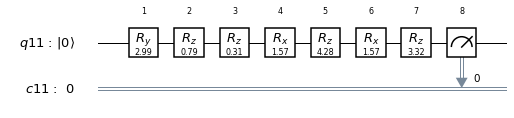

In [38]:
# Draw the circuit
my_style = {'latexdrawerstyle': False, 'cregbundle': True, 'fold': 30, 'showindex': True}
qprog.draw(output='mpl', style=my_style)

In [41]:
mode = "NFS"
out = minimize(obj_simple, x0=2 * np.pi * np.random.rand(3), method="Powell")

In [42]:
# do the circuit (neural network) with the optimal parameters
opt_angles = out['x']
qprog = make_program([theta, phi], opt_angles)

In [43]:
QASM_source = qprog.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q11[1];
creg c11[1];
ry(2.98797789579958) q11[0];
rz(0.789805554415850) q11[0];
rz(8.89515197858799) q11[0];
rx(1.57079632679490) q11[0];
rz(6.14308213587254) q11[0];
rx(1.57079632679490) q11[0];
rz(7.13449483997346) q11[0];
measure q11[0] -> c11[0];



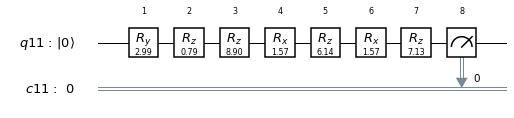

In [44]:
# Draw the circuit
my_style = {'latexdrawerstyle': False, 'cregbundle': True, 'fold': 30, 'showindex': True}
qprog.draw(output='mpl', style=my_style)

Date (DMY): 10/02/2019 11:59:44
{'0': 999, '1': 1}
theta = 2.987977895799584 phi = 0.7898055544158503


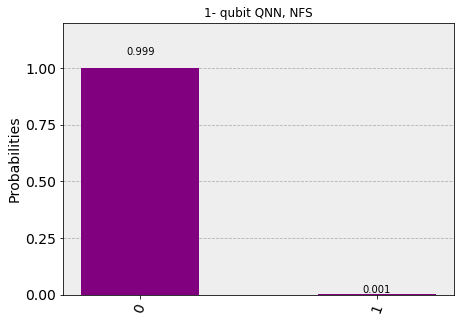

In [45]:
# show the output distribution
shots = 1000
backend_sim = Aer.get_backend('qasm_simulator')
dist = execute(qprog, backend_sim, shots=shots)
dist_count = dist.result().get_counts(qprog)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print(dist_count)
print('theta =', theta, 'phi =', phi)
plot_histogram(dist_count, color=['purple'], 
               title=str(n) + '- qubit QNN, ' + mode)

##  Training (NFS)

In [46]:
# fraction of total data to use as training data
train_frac = 0.7

In [47]:
# get some random angles
angs = 2 * np.pi * np.random.rand(3)
cost = obj(angs)

In [176]:
optimal_angles = [7.85082205, 0.01934754, 9.62729993]

If you chose to skip the training, you should not execute the next cell. Otherwise, continue through the notebook

In [48]:
# train the quantum neural network and time how long it takes
start = time.time()
out = minimize(fun=obj, x0=angs, method="Powell")
print("\nTotal training runtime took {} minutes.".format((time.time() - start) / 60))

The current value of the cost function is: 0.014285714285714285
Total training runtime took 1.8455156366030374 minutes.


In [49]:
# grab the optimal angles and minimal cost value
optimal_angles = out['x']
fval = out['fun']

# print them out
print(fval)
print(optimal_angles)

0.0
[3.321652   6.2743205  5.85861077]


In [50]:
# compute all the predictions of the quantum neural network
predictions = get_all_predictions(optimal_angles)

=============== Results of quantum neural network classification ===============
Out of 100 total data points:
The QNN was trained on 70.0% of the total data (70 training points).
The QNN classified 100 data points correctly (100.0% accuracy).


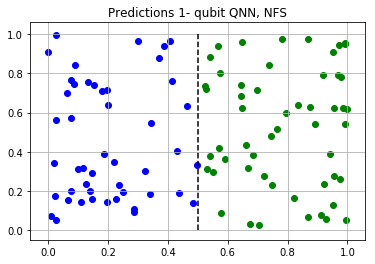

In [51]:
# compute statistics of the QNN
ntrain = int(train_frac * npoints)
ncorrect = npoints - sum(abs(predictions - labels))
acc = ncorrect / npoints * 100

# print them out
print(" Results of quantum neural network classification ".center(80, "="))
print("Out of {} total data points:".format(npoints))
print("The QNN was trained on {}% of the total data ({} training points).".format(train_frac * 100, ntrain))
print("The QNN classified {} data points correctly ({}% accuracy).".format(ncorrect, acc))
print("".center(80, "="))

# plot the points, line y = x, and prediction
plt.plot(ys, xs, '--k')
for i in range(npoints):
    if predictions[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)

plt.grid()
plt.title("Predictions " + str(n) + '- qubit QNN, ' + mode)
plt.show()

## Testing on device noise simulator

In [66]:
# Testing on device noise simulator
mode = "DNS"

In [67]:
qprog = make_program([theta, phi], angles)
QASM_source = qprog.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q11[1];
creg c11[1];
ry(2.98797789579958) q11[0];
rz(0.789805554415850) q11[0];
rz(0.314283559730307) q11[0];
rx(1.57079632679490) q11[0];
rz(4.27779036629818) q11[0];
rx(1.57079632679490) q11[0];
rz(3.31959735414771) q11[0];
measure q11[0] -> c11[0];



In [68]:
out = minimize(obj_simple, x0=2 * np.pi * np.random.rand(3), method="Powell")

In [69]:
# do the circuit (neural network) with the optimal parameters
opt_angles = out['x']
qprog = make_program([theta, phi], opt_angles)

In [70]:
QASM_source = qprog.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q11[1];
creg c11[1];
ry(2.98797789579958) q11[0];
rz(0.789805554415850) q11[0];
rz(-1.51785048443617) q11[0];
rx(1.57079632679490) q11[0];
rz(0.248786966568569) q11[0];
rx(1.57079632679490) q11[0];
rz(9.26351197606004) q11[0];
measure q11[0] -> c11[0];



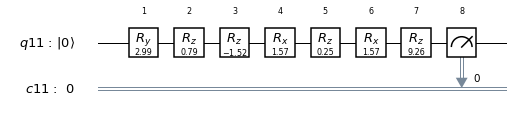

In [71]:
# Draw the circuit
my_style = {'latexdrawerstyle': False, 'cregbundle': True, 'fold': 30, 'showindex': True}
qprog.draw(output='mpl', style=my_style)

Date (DMY): 10/02/2019 12:45:53
{'0': 904, '1': 96}
theta = 2.987977895799584 phi = 0.7898055544158503


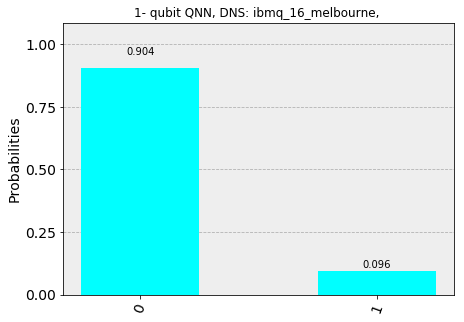

In [72]:
# show the output distribution (DNS)
mode = "DNS"
dist = execute(qprog, backend_noise, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates, shots = shots)
dist_count = dist.result().get_counts(qprog)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("Date (DMY):", time_exp)
print(dist_count)
print('theta =', theta, 'phi =', phi)
plot_histogram(dist_count, color=['cyan'], 
               title= str(n) + '- qubit QNN, ' + mode + ': {}, '.format(device.name()))

##  Training (DNS)

In [73]:
# fraction of total data to use as training data (DNS)
train_frac = 0.7

In [74]:
# get some random angles
angs = 2 * np.pi * np.random.rand(3)
cost = obj(angs)

In [75]:
optimal_angles = [7.85082205, 0.01934754, 9.62729993]

If you chose to skip the training, you should not execute the next cell. Otherwise, continue through the notebook

In [76]:
# train the quantum neural network and time how long it takes
start = time.time()
out = minimize(fun=obj, x0=angs, method="Powell")
print("\nTotal training runtime took {} minutes.".format((time.time() - start) / 60))

The current value of the cost function is: 0.014285714285714285
Total training runtime took 6.603797650337219 minutes.


In [77]:
# grab the optimal angles and minimal cost value
optimal_angles = out['x']
fval = out['fun']

# print them out
print(fval)
print(optimal_angles)

0.0
[3.47838504 6.18048312 3.49508897]


In [78]:
# compute all the predictions of the quantum neural network
predictions = get_all_predictions(optimal_angles)

=============== Results of quantum neural network classification ===============
Out of 100 total data points:
The QNN was trained on 70.0% of the total data (70 training points).
The QNN classified 99 data points correctly (99.0% accuracy).


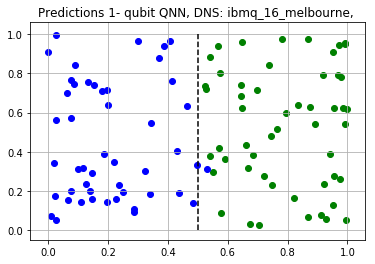

In [79]:
# compute statistics of the QNN # previous experiment
ntrain = int(train_frac * npoints)
ncorrect = npoints - sum(abs(predictions - labels))
acc = ncorrect / npoints * 100

# print them out
print(" Results of quantum neural network classification ".center(80, "="))
print("Out of {} total data points:".format(npoints))
print("The QNN was trained on {}% of the total data ({} training points).".format(train_frac * 100, ntrain))
print("The QNN classified {} data points correctly ({}% accuracy).".format(ncorrect, acc))
print("".center(80, "="))

# plot the points, line y = x, and prediction
plt.plot(ys, xs, '--k')
for i in range(npoints):
    if predictions[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)

plt.grid()
plt.title("Predictions " + str(n) + '- qubit QNN, ' + mode + ': {}, '.format(device.name()))
plt.show()

### References:

[1] https://github.com/QuantumAI-lib/NISQAI/blob/master/examples/one-qubit-classifier/one-qubit-classifier.ipynb

[2] https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/community/terra/qis_adv/Multi-Qubit_W_States_with_Tomography.ipynb

[3] Smolin, J. A., Gambetta, J. M. & Smith, G. (2012). Efficient method for computing the maximum-likelihood quantum state from measurements with additive gaussian noise. Phys. Rev. Lett 108(7). https://link.aps.org/doi/10.1103/PhysRevLett.108.070502

[4] Preskill, J. (2018) Quantum Computing in the NISQ era and beyond. Quantum 2, 79 (2018). https://arxiv.org/abs/1801.00862

[5] https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/terra/summary_of_quantum_operations.ipynb